# A normal distribution sampler in python

Last year, I had the pleasure of attending a tutorial with the great [Petros Dellaportas](http://www.homepages.ucl.ac.uk/~ucakpde/#), a one-day primer in bayesian inference. One of the main sessions was about Markov chain Monte Carlo sampling, the technique whose name inspired one of the all-time greatest blog names (and blogs) ever: ['While my MCMC gently samples'](https://twiecki.io/)... and _also_ a game-changing statistical insight when it comes to sampling from complex statistical distributions. Following the session, I caught up with Petros and asked a dumb but useful question: 

<p><center>'So, I kind of understand MCMC now... but why does it matter?!'</center></p>

Petros being Petros, he was more than equal to my question:

<p><center>'MCMC is a tool to sample from complex distributions. Let's start with a simple distribution, the Normal Distribution. After this session, go and write a normal distribution sampler. Then, go and look up the Box-Mueller method, and you'll realise that MCMC matters - effective sampling from distributions is not trivial!'</center></p>

So, here's my naive attempt at sampling from the normal distribution. 

In [1]:
import numpy as np
from numpy.random import rand

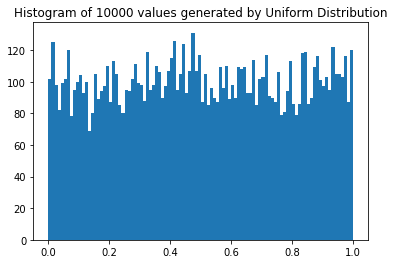

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 
n = 10000

test_set = rand(n)

plt.hist(test_set, bins=100)  
plt.title("Histogram of %i values generated by Uniform Distribution" %(n))
plt.show()

The probability density function of the normal distribution is defined as:

$$ f(x|\mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma ^2}}e ^ {- \frac{(x-\mu)^2}{2\sigma^2}}  $$

In [3]:
from math import pi

def norm(x_array, m, s):
    point_array = 1/np.sqrt(2* pi * s ** 2) * np.exp((-(x_array - mu)**2)/2*s**2)
    return(point_array)

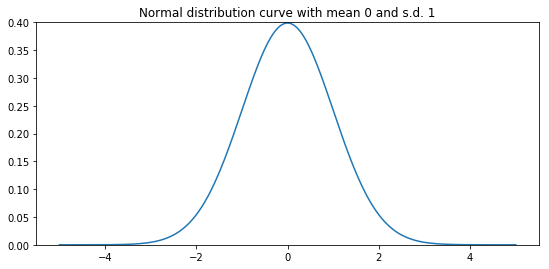

In [4]:
sigma = 1
mu = 0

x = np.linspace(-5,5,200)
y = norm(x, mu, sigma)


fig = plt.figure(figsize=(9,9))

n_axes = fig.add_subplot(211)

n_axes.set_autoscaley_on(False)
n_axes.set_ylim([0,0.4])

n_axes.plot(x, y)
plt.title("Normal distribution curve with mean %i and s.d. %i" %(mu, sigma))
plt.show()

Now, if we want to use the uniform sampler to generate a sample distribution X, such that $ X \sim N(0, 1)$, we need to know how to reshape our uniform distribution. To do this, we'll split the normal curve into strips, calculate the area under the curve for each strip, and use this to tell us how many uniformly distributed samples we need for each strip. 

Given an interval, we can calculate the y values at the beginning and end of the interval, then we use the trapezium rule to get the area of this slice:

$$ \frac{1}{2} * (a + b) * width $$  



In [5]:
sigma = 1
mu = 0


x_int = np.array([0,0.25])
x_width = x_int.max() - x_int.min()
y_vals = norm(x_int, mu, sigma)
area = 0.5 * y_vals.sum()*x_width

print(y_vals)
print(area)

[0.39894228 0.38666812]
0.09820129965053524


In [6]:
## function to calculate the trapezium area

def trap_area(y1, y2, width):
    return 0.5*(y1 + y2)* width

trap_area(*y_vals, x_width)

0.09820129965053524

In [7]:
sigma = 1
mu = 0
n_sigma = 4

## set our full interval to be 4 s.d. from the mean
## so with X~(0,1) we'll get an interval of (-4, 4)

interval = np.array([mu - sigma * n_sigma,mu + sigma * n_sigma])

## split this into k strips, which will control how fine-grain our slices are (let's say k = 80, intervals of 0.1)
k = 100

strip_width = (interval[1]-interval[0])/k
sub_strips = np.linspace(*interval, k + 1) ## 81 edges gives 80 strips
sub_strips_pairs = [np.array([sub_strips[p],sub_strips[p+1]]) for p in range(k)]


## also set how many samples we want 
n = 10000

## the area of the strip tells us how many values we want to select, as a proportion of n
## create an array of areas

areas = np.array([trap_area(*norm(s, mu, sigma), strip_width) for s in sub_strips_pairs])

print(areas.sum()) ## Check that my probabilities summed to 1. They don't quite, because the trapezium rule is an estimate.
                   ## We'll need a way to make sure this discrepancy doesn't affect the number of samples we want to produce at the end

0.99993608729814


In [8]:
## sense check


##  we can generate these using a uniformly distributed rv within that interval
bin_counts = np.round(areas * n)


x = bin_counts[2]
interval = sub_strips_pairs[2]


print("%i values in the interval (%f,%f)" %(x, *interval))
p = rand(int(x)) * strip_width + interval[0]
p.shape

0 values in the interval (-3.840000,-3.760000)


(0,)

Implementing largest remainder method to distribute remainder correctly

In [9]:
leftover = int(n - (np.floor(areas * n) ).sum())

## sort by decimal parts, and distribute leftovers 
# index = np.arange(len(bin_counts))
rounded_down = areas * n - np.floor(areas * n)


In [10]:
leftover

54

In [11]:
len(areas)

100

In [12]:
adjusted_bin_counts = np.floor(areas * n)

In [13]:
areas.sum()

0.99993608729814

In [14]:
rounded_down

array([0.12701709, 0.17371638, 0.23607186, 0.31876641, 0.4276867 ,
       0.57016926, 0.75527783, 0.99411024, 0.30013138, 0.68952575,
       0.1815606 , 0.79894677, 0.56818114, 0.51985024, 0.68887119,
       0.11464215, 0.84107206, 0.91645707, 0.39317079, 0.32713638,
       0.77705194, 0.80334608, 0.46684872, 0.82717297, 0.94081711,
       0.85901118, 0.62534961, 0.27326956, 0.82345226, 0.2812416 ,
       0.63418859, 0.84984081, 0.87390224, 0.62888827, 0.01339411,
       0.9020807 , 0.14646061, 0.57653834, 0.00332516, 0.22220982,
       0.01712529, 0.16540982, 0.44322109, 0.63132685, 0.52106752,
       0.92026658, 0.65885651, 0.59399068, 0.61442683, 0.64399437,
       0.64399437, 0.61442683, 0.59399068, 0.65885651, 0.92026658,
       0.52106752, 0.63132685, 0.44322109, 0.16540982, 0.01712529,
       0.22220982, 0.00332516, 0.57653834, 0.14646061, 0.9020807 ,
       0.01339411, 0.62888827, 0.87390224, 0.84984081, 0.63418859,
       0.2812416 , 0.82345226, 0.27326956, 0.62534961, 0.85901

In [15]:
#  = np.argpartition(a, -4)[-4:

largest_remainders = np.argpartition(rounded_down, -leftover)[-leftover:]


In [16]:
np.argpartition(rounded_down, 0)

array([38,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37,  0, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [17]:
largest_remainders

array([94,  5, 47, 62, 37, 51, 52, 48, 73, 69, 56, 26, 43, 30, 33, 66, 49,
       11, 64, 53, 50, 67, 68, 46, 45, 71,  6,  7, 74, 75, 76, 35, 78, 79,
       32, 31, 82, 83, 28, 85, 25, 24, 88, 23, 90, 21, 92, 93, 20, 17, 16,
        9, 14, 54])

In [18]:
adjusted_bin_counts[largest_remainders] += 1

In [19]:
sum(bin_counts - adjusted_bin_counts)

6.0

In [20]:
normal_sample = np.array([])

for i in range(k):
    count = adjusted_bin_counts[i]
    strip = sub_strips_pairs[i]
    sample = rand(int(count)) * strip_width + strip[0]
    normal_sample = np.append(normal_sample, sample)
    
len(normal_sample) ## sanity check

10000

In [21]:
normal_sample2 = np.array([])

for i in range(k):
    count = adjusted_bin_counts[i]
    strip = sub_strips_pairs[i]
    sample = rand(int(count)) * strip_width + strip[0]
    normal_sample2 = np.append(normal_sample2, sample)
    
len(normal_sample2) ## sanity check

10000

In [22]:
normal_sample == normal_sample2

array([False, False, False, ..., False, False, False])

In [23]:
idx = np.random.randint(len(normal_sample))
normal_sample[idx]

0.8149647047272378

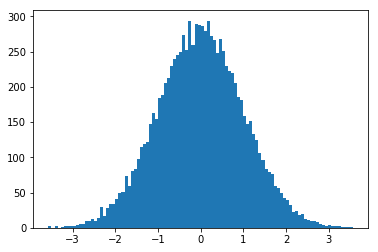

In [24]:
plt.hist(normal_sample, bins=100)
plt.show()

In [25]:
g = (trap_area(*norm(s, mu, sigma),0.1) for s in sub_strips_pairs)

In [26]:
class normal_distribution():
    
    def __init__(self, mu, sigma, num_sigma=4):
        self.mu = mu
        self.sigma = sigma
        self.tails = np.array([mu - sigma * num_sigma, mu + sigma * num_sigma])
        self.normal_sample = np.array([])
    
    def _generate_sample(self, bins, num_samples):
        
        strip_width = (self.tails[1] - self.tails[0]) / bins            
        sub_strips = np.linspace(*self.tails, bins + 1)
        sub_strips_pairs = [np.array([sub_strips[p], sub_strips[p + 1]]) for p in range(bins)]
    
        ## the area of the strip tells us how many values we want to select, as a proportion of the total number of samples
        ## create an array of areas

        area_array = np.array([self._trapezium_area(*self._normal_pdf(s, self.mu, self.sigma), strip_width) \
                               for s in sub_strips_pairs])

        bin_counts = np.round(area_array * num_samples)
        if bin_counts.sum() > num_samples:   
            print(bin_counts.sum())

        for i in range(bins):
            count = bin_counts[i]
            strip = sub_strips_pairs[i]
            strip_sample = rand(int(count)) * strip_width + strip[0]
            self.normal_sample = np.append(self.normal_sample, strip_sample)
            
            
    def _trapezium_area(self, y1, y2, width):
        return 0.5 * (y1 + y2) * width
          
    def _normal_pdf(self, x_array, mu, sigma):
        point_array = 1 / np.sqrt(2 * pi * sigma ** 2) * np.exp((-(x_array - mu) ** 2) / 2 * sigma ** 2)
        return(point_array)
        
    
    def sample(self,n, bins=80, num_samples=10000):
        
        self._generate_sample(bins, num_samples)
    
        if n > len(self.normal_sample):
            raise IndexError
        
        idx = np.random.randint(0,len(self.normal_sample), n)
        
        return self.normal_sample[idx]
        

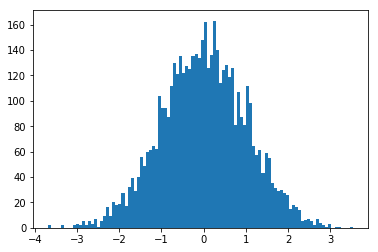

In [27]:
my_sampler = normal_distribution(0,1)
plt.hist(my_sampler.sample(5000), bins=100)
plt.show()

In [28]:
from time import time

t = []

for n in range(50):
    t0 = time()
    sampler = normal_distribution(0,1)
    try:
    
        sampler.sample(1, bins=100, num_samples = n * 100000)
    except:
        pass
    t1 = time()
    
    t.append(t1 - t0)

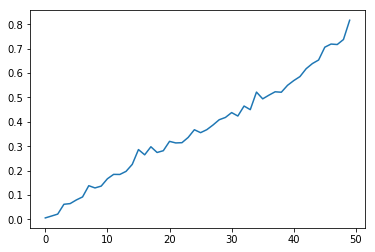

In [29]:
plt.plot(t)

In [30]:
sampler.normal_sample.shape

(4899686,)

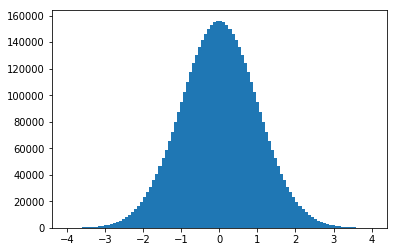

In [31]:
plt.hist(sampler.normal_sample, bins=100)
plt.show()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


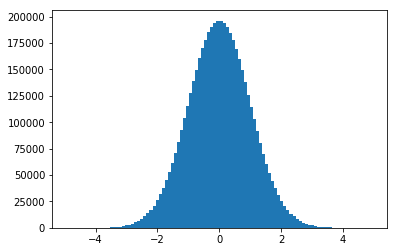

In [195]:
%time
plt.hist(np.random.normal(size=5000000), bins=100)
plt.show()

In [196]:
from scipy.stats import normaltest

print(normaltest(np.random.normal(size=5000000)))

print(normaltest(sampler.sample(n=500000)))

NormaltestResult(statistic=1.2639806695145386, pvalue=0.5315328192476083)
NormaltestResult(statistic=1.348598414470867, pvalue=0.5095133587983863)


NameError: name 'normaltest' is not defined

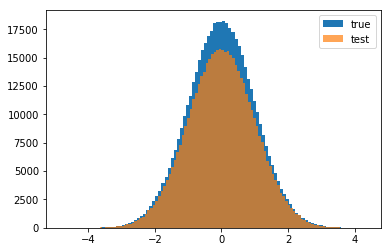

In [32]:
true = np.random.normal(size=500000)
test = sampler.sample(n=500000)

plt.hist(true, bins=100,label='true')
plt.hist(test, alpha=0.7, bins=100, label='test')
plt.legend(prop={'size': 10})

print(normaltest(true), '\n', normaltest(test))
plt.show()

In [ ]:
from scipy import stats

test_stat, pvalue = stats.kstest(test, 'norm', args=(0, 4), N=5000000)
print("sample_N(0,1) vs. N(0, 1): KS=%.4f with p-value = %.4f." % (test_stat, pvalue))


In [33]:
from math import sin, cos, pi, log, sqrt

## The Box-Mueller implementation

This can be easily seen by simply multiplying the two 1D distributions $e−x2e−y2=e−(x2+y2)=e−r2$

In [34]:
# %%timeit
x1s = []
x2s = []

y1s = []
y2s = []
n = 10000

for i in range(n):

    y1 = np.random.random()
    y2 = np.random.random()

    x1 = sqrt(-2 * log(y1)) * cos(2 * pi * y2)
    x2 = sqrt(-2 * log(y2)) * sin(2 * pi * y1)  
    
    y1s.append(y1)
    y2s.append(y2)
    
    x1s.append(x1)
    x2s.append(x2)

https://upload.wikimedia.org/wikipedia/commons/1/1f/Box-Muller_transform_visualisation.svg

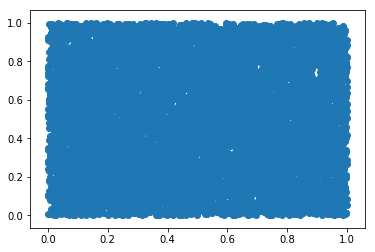

In [35]:
plt.scatter(y1s,y2s)

plt.show()

In [36]:
x = np.linspace(0,1, 21)
y = np.linspace(0,1, 21)

xv, yv = np.meshgrid(x, y)

x1s = []
x2s = []


for y1,y2 in zip(xv.flatten(), yv.flatten()):
    

    if y1 == 0 and y2 > 0:
        x1 = 0
        x2 = sqrt(-2 * log(y2)) * sin(2 * pi * y1)
    
    elif y1 > 0 and y2 == 0:
        x1 = sqrt(-2 * log(y1)) * sin(2 * pi * y2)
        x2 = 0
    
    elif y1 == y2 == 0:
        next
    
    else:
        x1 = sqrt(-2 * log(y1)) * cos(2 * pi * y2)
        x2 = sqrt(-2 * log(y2)) * sin(2 * pi * y1)  
    
    x1s.append(x1)
    x2s.append(x2)


In [37]:
y1 = 0.5
y2 = 0.7
x1 = sqrt(-2 * log(y1)) * cos(2 * pi * y2)
x2 = sqrt(-2 * log(y2)) * sin(2 * pi * y1)  
print(x1,x2)

-0.36383970630467133 1.0343372142608848e-16


In [38]:
log(0.05)

-2.995732273553991

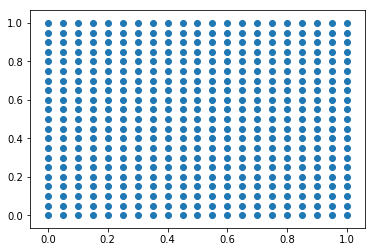

In [39]:
# plt.figure(figsize=(20,20))
plt.scatter(xv, yv)
plt.show()

In [40]:
xv.flatten()[225]
# yv.flatten()[225]

0.75

In [41]:
x1s[10]
x2s[10]


0

In [42]:
x_circle = []
y_circle = []

for i in np.linspace(0,2 * pi,100):
    x_circle.append(sin(i))
    y_circle.append(cos(i))

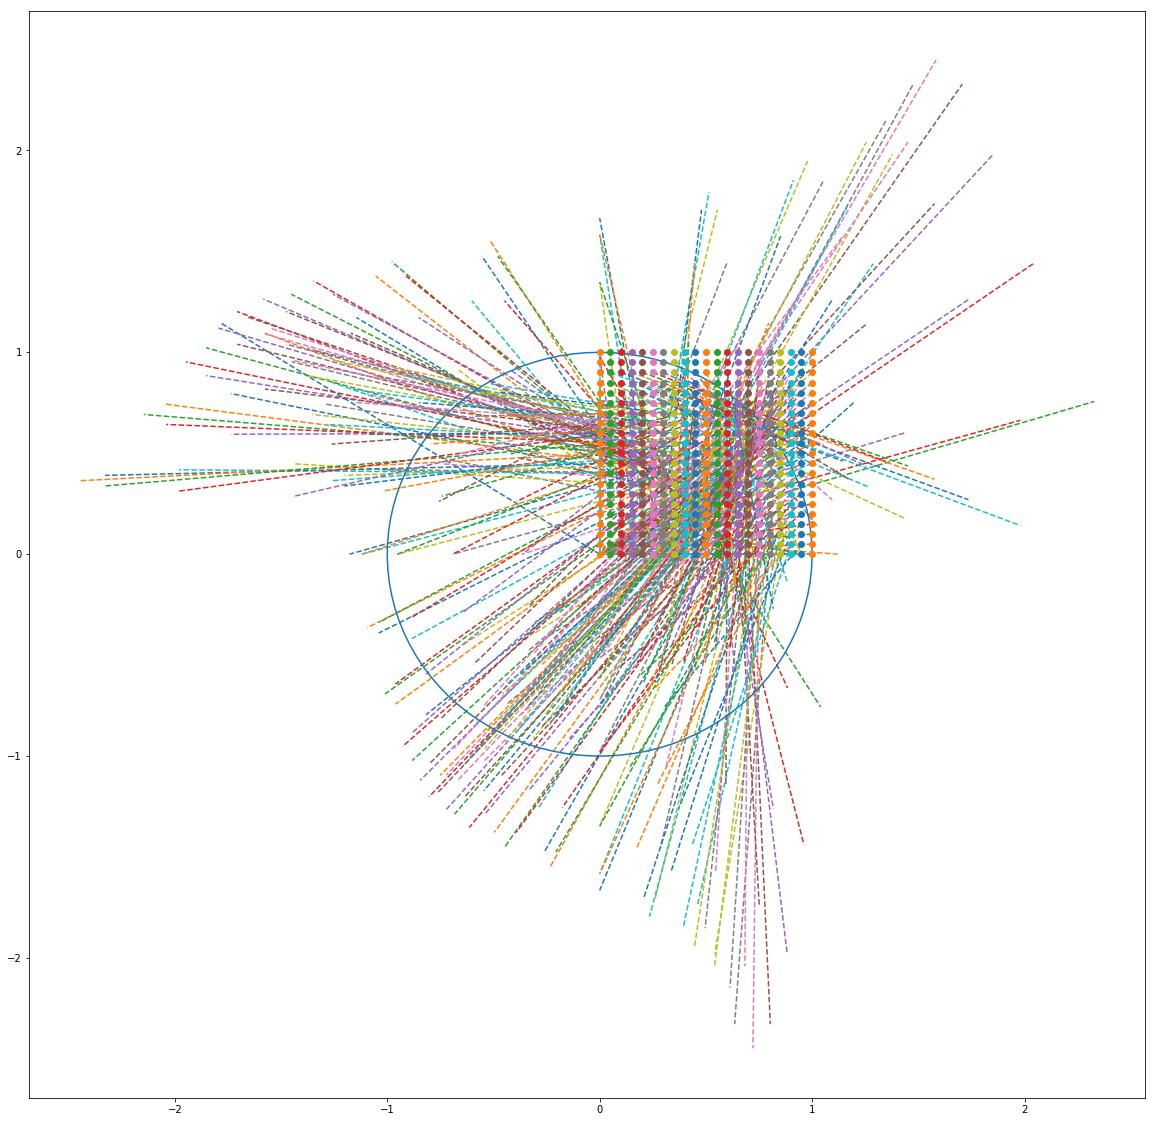

In [43]:
plt.figure(figsize=(20,20))


for i in range(400):
    plt.plot([xv.flatten()[i], x1s[i]],[yv.flatten()[i], x2s[i]], '--')
    

plt.plot(x_circle, y_circle)    
plt.plot(xv, yv, 'o')
plt.show()

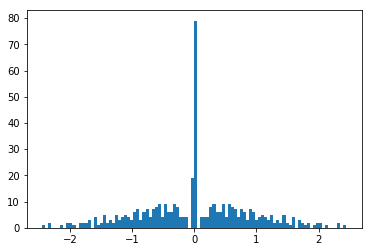

In [44]:
plt.hist(x1s, bins=100)
plt.show()

Wait... so that's it?! What is going on here?

IndexError: list index out of range

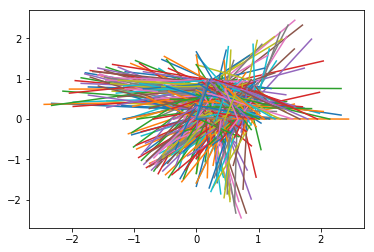

In [45]:

for i in range(1000):
    plt.plot([y1s[i],x1s[i]],[y2s[i],x2s[i]])
plt.show()

### Marsaglia polar method

In [52]:
def reject_r2():
    r2 = 1
    while r2 >= 1:
        y1 = np.random.random() * 2 - 1
        y2 = np.random.random() * 2 - 1
        r2 = y1 ** 2 + y2 ** 2
    return r2, y1, y2

def transform_r2(r2):
    return sqrt( -2 * log(r2) / r2)   

In [53]:
%%timeit



x1s = []
x2s = []

for i in range(n):    
    r2, y1, y2 = reject_r2()
    transformed_r2 = transform_r2(r2)

    x1 = transformed_r2  * y1
    x2 = transformed_r2 * y2
    
    x1s.append(x1)
    x2s.append(x2)

29.4 ms ± 305 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


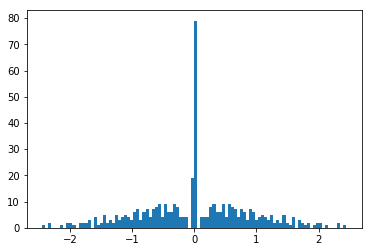

In [54]:
plt.hist(x1s, bins=100)
plt.show()

In [75]:
reject_r2()

(0.07246184635933628, -0.20772196238113638, 0.17121166053708503)

### Ziggurat

Given a monotone decreasing probability density function f(x), defined for all x ≥ 0, the base of the ziggurat is defined as all points inside the distribution and below y1 = f(x1). This consists of a rectangular region from (0, 0) to (x1, y1), and the (typically infinite) tail of the distribution, where x > x1 (and y < y1).

This layer (call it layer 0) has area A. On top of this, add a rectangular layer of width x1 and height A/x1, so it also has area A. The top of this layer is at height y2 = y1 + A/x1, and intersects the density function at a point (x2, y2), where y2 = f(x2). This layer includes every point in the density function between y1 and y2, but (unlike the base layer) also includes points such as (x1, y2) which are not in the desired distribution.

Further layers are then stacked on top. To use a precomputed table of size n (n = 256 is typical), one chooses x1 such that xn = 0, meaning that the top box, layer n − 1, reaches the distribution's peak at (0, f(0)) exactly.

Layer i extends vertically from yi to yi+1, and can be divided into two regions horizontally: the (generally larger) portion from 0 to xi+1 which is entirely contained within the desired distribution, and the (small) portion from xi+1 to xi, which is only partially contained. 

In [327]:
from scipy.special import erf, erfc

def gauss(x):
    return np.exp((- x ** 2) / 2)


def inverse_gauss(x):
    return np.sqrt(- 2 * np.log(x))

def unnormalised_erfc(x):
    return np.sqrt(np.pi / 2) * erfc(x / np.sqrt(2))


In [328]:
from scipy.optimize import bisect

n = 5

def find_x1(x, n):
    y = gauss(x)
    area = np.sqrt(np.pi / 2) * erfc(x / np.sqrt(2)) + x * y
    for i in range(n):
        y_new = y + area / x
        x_new = inverse_gauss(y_new)
        y = y_new
        x = x_new
    if np.isnan(y):
        return -1
    else:
        return 1 - y

x_1 = bisect(lambda x:find_x1(x, n), 1, 5)
print(x_1)

2.1760594405477605


/home/tms/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


In [329]:
## want to find x_1 such that base_area - top area = 0

def calculate_table(x, n):
    y = gauss(x)
    areas = []
    xs = []
    ys = []
    area = np.sqrt(np.pi / 2) * erfc(x / np.sqrt(2)) + x * y
    for i in range(n):
        areas.append(area)
        y_new = y + area / x
        x_new = inverse_gauss(y_new)
        xs.append(x)
        ys.append(y)
        area = x * (y_new - y)
        y = y_new
        x = x_new
    return areas, ys, xs

In [330]:
areas, ys, xs = calculate_table(x_1, 5)
print(areas, ys, xs)

[0.2409413294153891, 0.24094132941538912, 0.2409413294153891, 0.24094132941538912, 0.24094132941538915] [0.09370372421229677, 0.2044274135223365, 0.3396451463049638, 0.503596046339135, 0.7092988994903983] [2.1760594405477605, 1.7818767143708916, 1.4695944295833159, 1.1713076689228679, 0.8288284048203388]


/home/tms/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


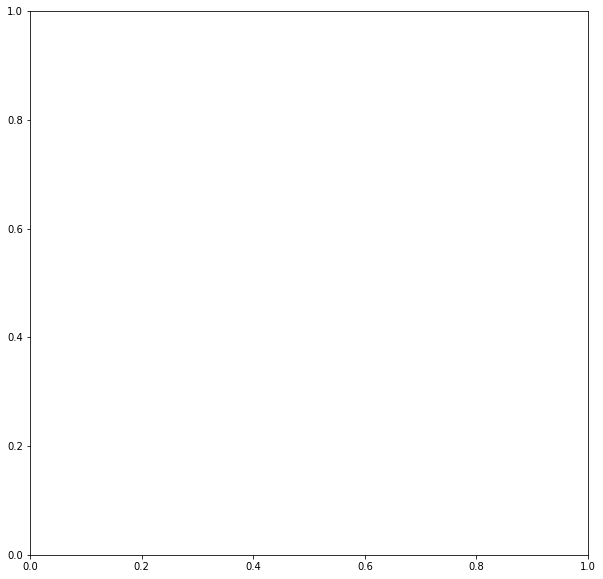

In [335]:
fig, ax = plt.subplots(figsize=(10,10))

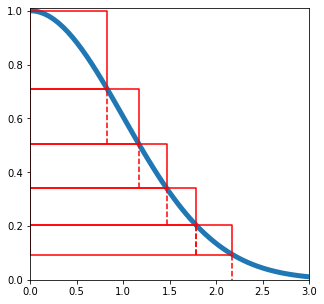

In [356]:
x = np.linspace(0,3,60)
y = gauss(x)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x, y, linewidth=5)
ax.set_xlim(0,3)
ax.set_ylim(0,1.01)


def plot_ziggurat(x, yl, yu):
    ax.plot([0, x, x, 0, 0],[yl, yl, yu, yu, yl], color='r')
plot_ziggurat(xs[4], ys[4],1)
ax.plot([xs[0], xs[0]],[ys[0], 0], "--", color='r')

for i in range(3, -1, -1):
    ax.plot([xs[i + 1], xs[i + 1]],[ys[i], ys[i + 1]], "--",  color='r')
    plot_ziggurat(xs[i], ys[i],ys[i + 1])
ax.plot([xs[i + 1], xs[i + 1]],[ys[i], ys[i + 1]], "--",  color='r')


For $n$ boundaries:

(1) Draw a boundary $x_{i}$ at random, with probability $1/n$

(2) Draw a random number $0 \leq u < 1$

If u = 0, 

If $ux_i \leq x_{i + 1}$, x is clearly within the distribution, so return x

Else test  

in the box as z = U0xi for i >0 and z= U0 V/f(x1) for i= 0.

(3) If z < x_{i+1} accept z.

(4.1) If i= 0, accept a v from the tail using [Marsaglia 1964]

(4.2) Else if i > 0 and U1[f(xi)−f(xi+1)]< f(z)−f(xi+1) accept z


In [42]:
y_1 = gauss(x_1)

area = np.sqrt(np.pi / 2) * erfc(x_1 / 2 ** 2) + x_1 * y_1
xs = [0, x_1]
ys = [0, y_1]

x_i = x_1

for i in range(n):
    y_i = ys[-1] + area / x_i
    x_i = inverse_gauss(y_i)
#     print(x_i)
    ys.append(y_i)
    xs.append(x_i)

/home/tms/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


In [355]:
xs

[2.1760594405477605,
 1.7818767143708916,
 1.4695944295833159,
 1.1713076689228679,
 0.8288284048203388]

In [21]:
# draw a box at random
i = 3
# xi = np.random.choice(len(xs))
box = xs[i] # this is actually x2, as we have a 0 in xs, then the line x0, x1, finally x2

# draw a random number in the box
u0, u1 = np.random.random(2)
z = u0 * box
if z < xs[i + 1]:
    print(z, 'accept')
else:
    lhs = u1 * (gauss(xs[i]) - gauss(xs[i + 1]))
    rhs = gauss(z) - gauss(xs[i + 1])
    if lhs < rhs:
        print(z, 'accept')
    else:
        print('reject')

0.7936808601406865 accept
